In [1]:
import os
import glob

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as img

# keras-ocr
import keras_ocr

# tesseract
import pytesseract
from PIL import Image
from pytesseract import Output
import re

# Google OCR API
from google.cloud import vision
import io
from PIL import ImageDraw

In [2]:
data_path = os.getenv('HOME')+'/aiffel/ocr_python/snacks/'

In [3]:
images_path = glob.glob(data_path+"*.jpg")
images_path

['/aiffel/aiffel/ocr_python/snacks/snacks9.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks10.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks13.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks2.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks5.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks3.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks14.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks6.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks8.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks4.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks7.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks15.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks1.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks11.jpg',
 '/aiffel/aiffel/ocr_python/snacks/snacks12.jpg']

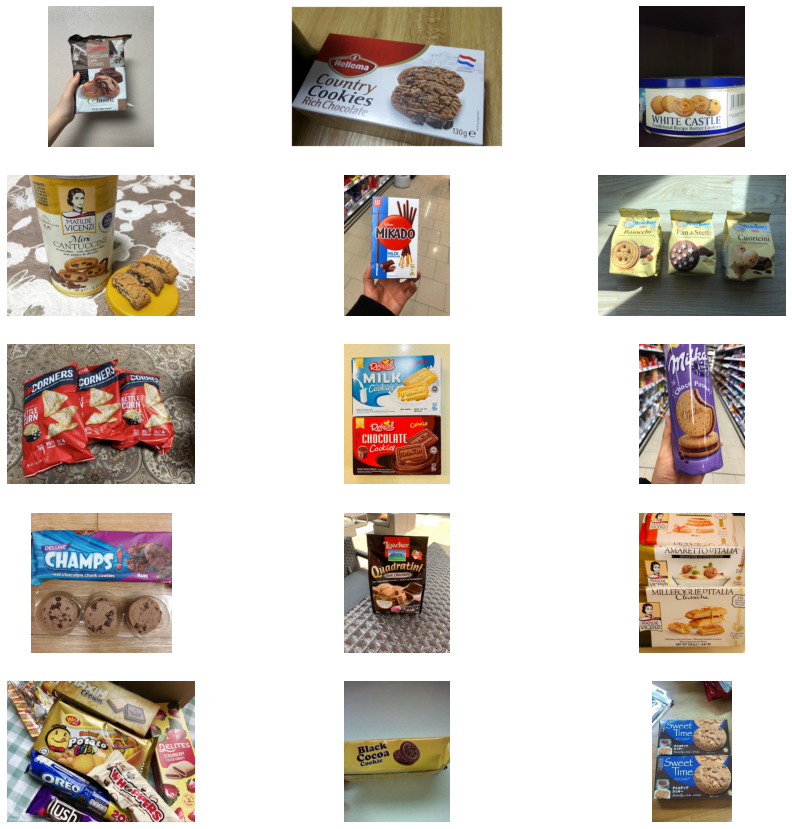

In [4]:
plt.figure(figsize=(15, 15))

for i, image in enumerate(images_path,1):
    plt.subplot(5, 3, i)
    plt.imshow(img.imread(image))
    plt.axis('off')

In [5]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [6]:
images = [keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

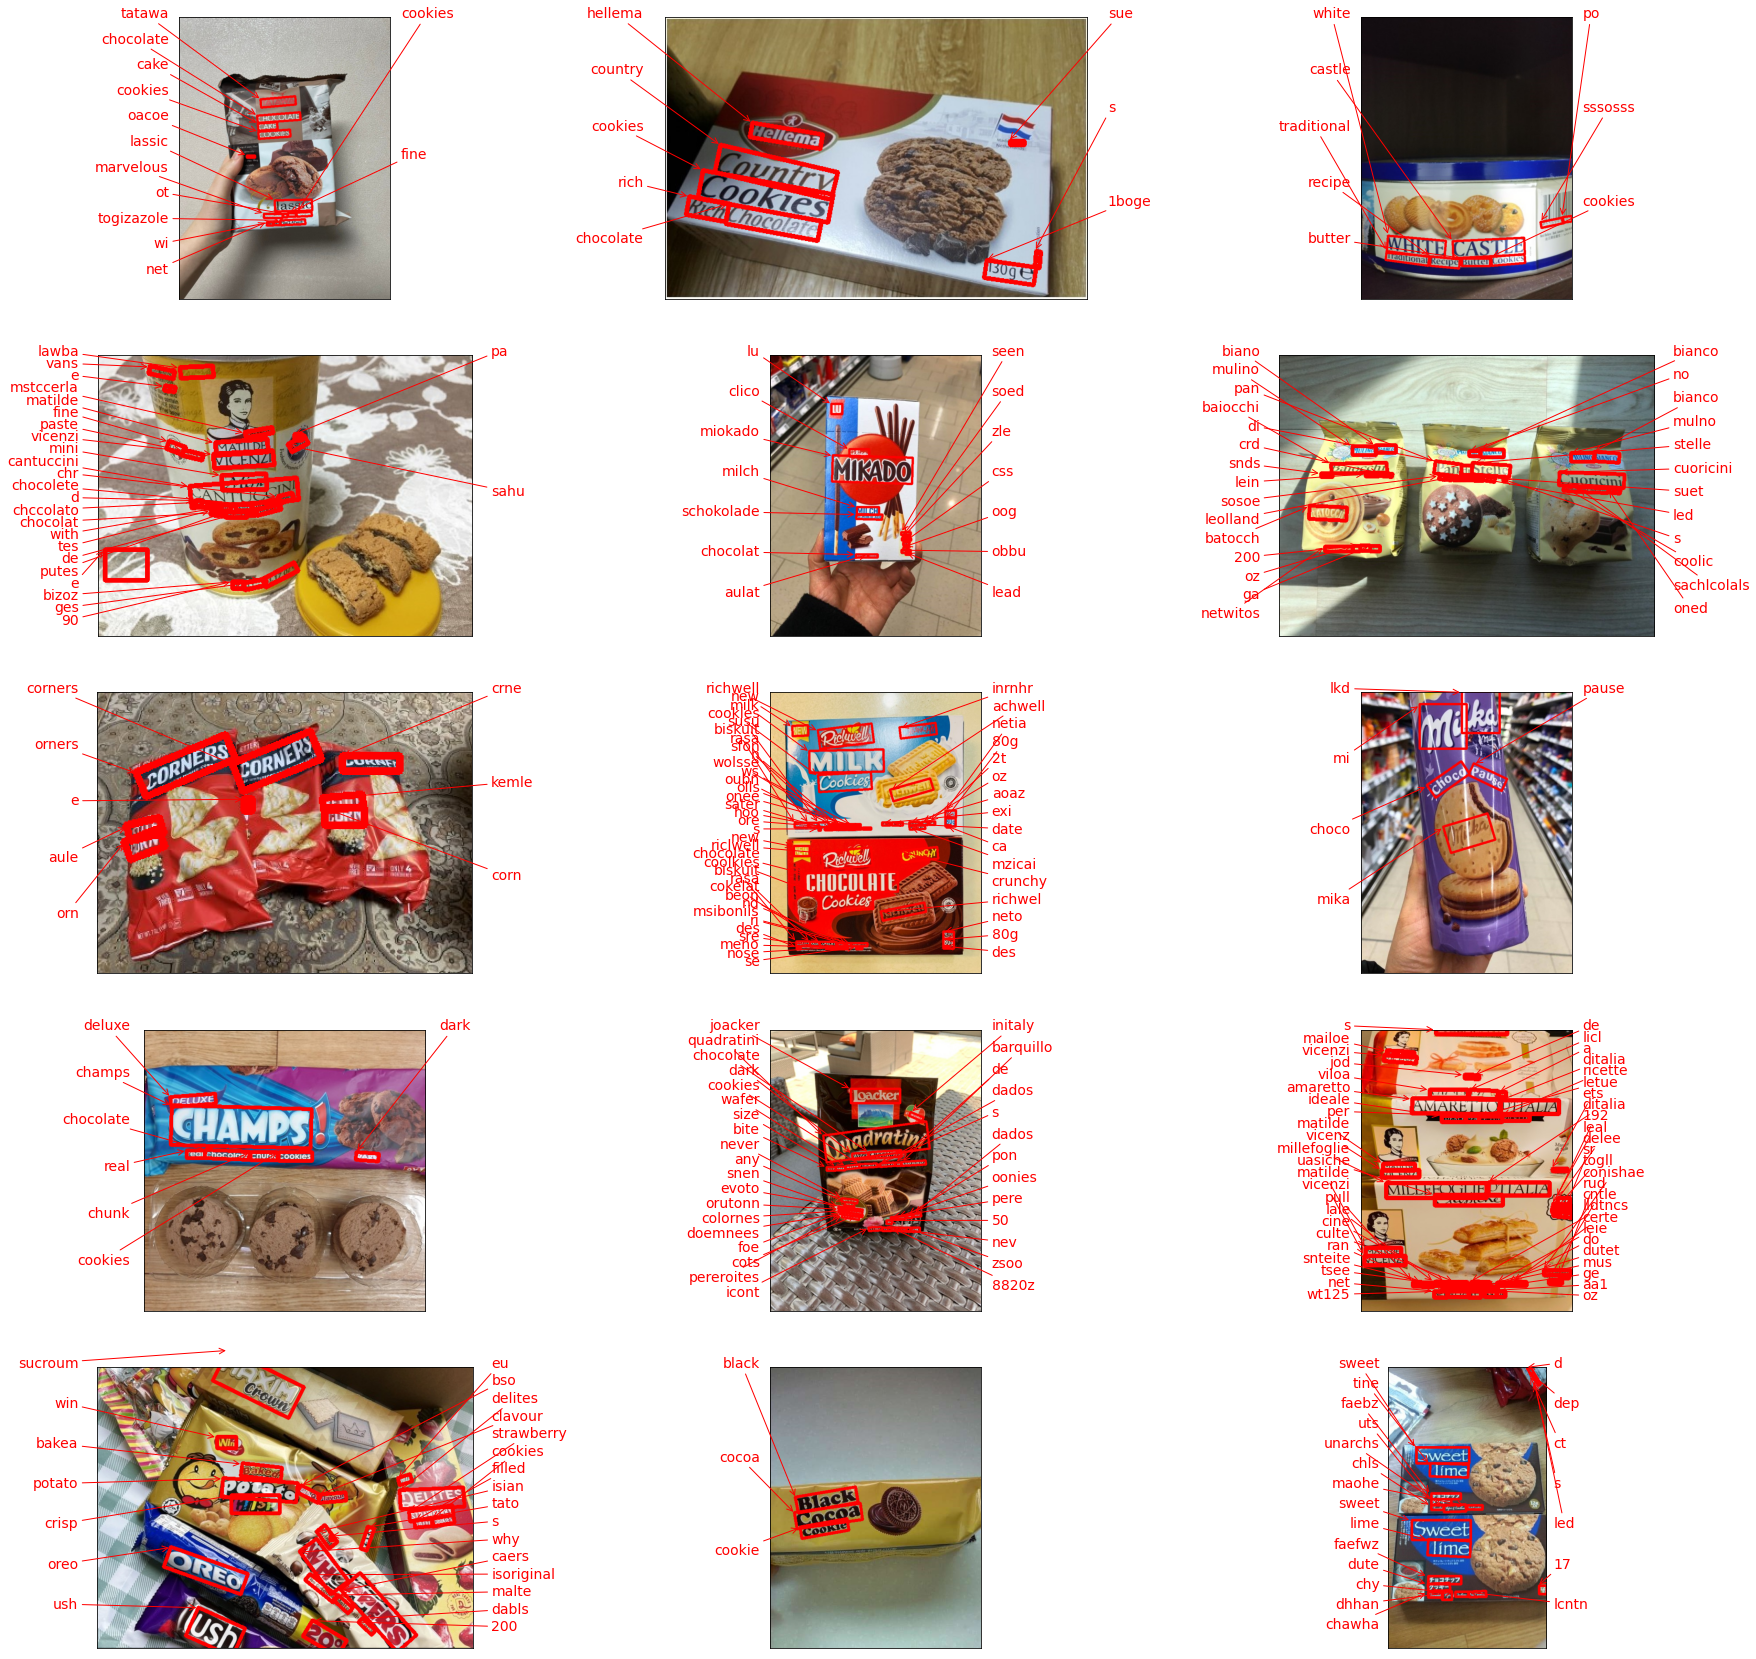

In [7]:
fig, axs = plt.subplots(5, 3, figsize=(30, 30))
for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[3*a+b], 
                                    predictions=predictions[3*a+b][0], ax=axs[a,b])

In [8]:
def detect_box(image_path):
    filename = os.path.basename(image_path)
    # read the image and get the dimensions
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['text'])

    # draw the bounding boxes on the image
    for i in range(n_boxes):
        if int(d['conf'][i]) > 1: # confidence가 1 이상인 값들만
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = d['text'][i]
            text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        1.5, (0, 0, 255), 3)
    return img

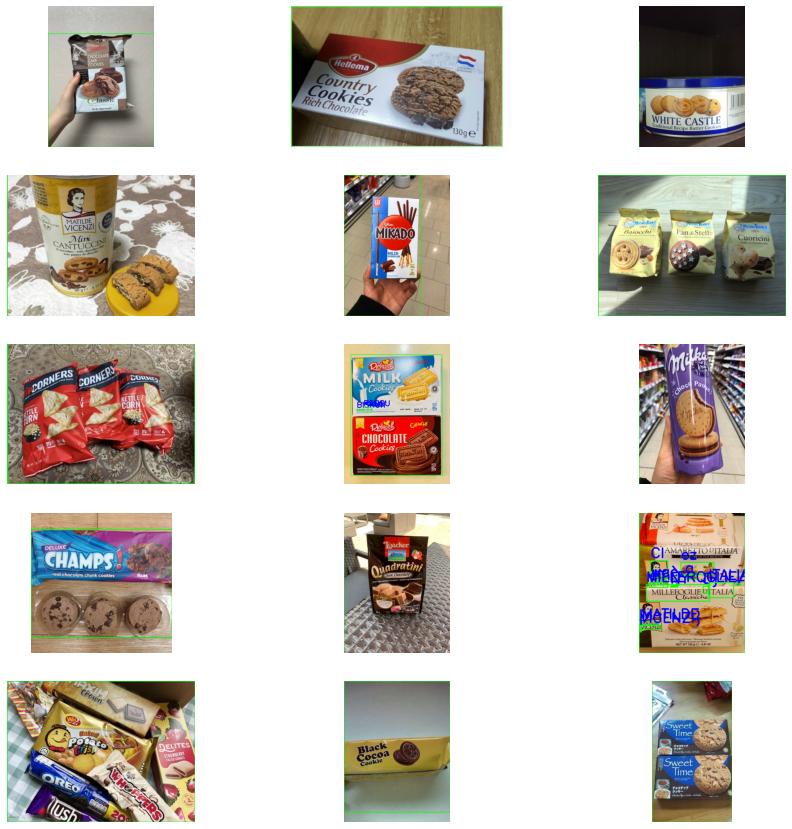

In [9]:
# confidence = 1
plt.figure(figsize=(15, 15))
for i,image_path in enumerate(images_path,1):
    img = detect_box(image_path)
    plt.subplot(5, 3, i)
    plt.imshow(img)
    plt.axis('off')

In [10]:
def extract_text(image_path):
    custom_oem_psm_config = r'--oem 3 --psm 11'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    txt = pytesseract.image_to_string(img, lang='eng',config=custom_oem_psm_config)
    txt = re.sub(r"\n+"," ",txt)
    return txt

In [11]:
extract_text(images_path[1])

'Eos ml > “TL Wen GRICS BOge \x0c'

In [12]:
for image_path in images_path:
    filename = os.path.basename(image_path)
    txt = extract_text(image_path)
    txt = "".join([c if ord(c) < 128 else "" for c in txt]).strip()
    print(f'========{filename}========')
    print(txt)

========snacks9.jpg========
Y co) UN KE Vi a SNe * a Py Net wr 709(2.4700)
========snacks10.jpg========
Eos ml > TL Wen GRICS BOge
========snacks13.jpg========
J 2) a Hl ws WHITE CAS, [ LI e Butter Cc
========snacks2.jpg========
LGA Cs S rd Me (TUC Oe Se
========snacks5.jpg========
> Bi 7 bi \\ MIKADO 'SCHOKOLADE MILCH iN eth
========snacks3.jpg========
2 ES tell a Uy )) se  us) 105 e \
========snacks14.jpg========
@ le ait oy Cy Friis i) _ ae = UN awh;  hs we
========snacks6.jpg========
yy > 7 t LU Cookies, NETO, xP DATE : 2022 02 27 80g BISKUIT RASA SUSU Sn diy 7 SORA ADI or reicat me  = ue we ab Cy tes A eee oe 7 et os = SJ x? Wa ey mel . EO eo ce ice i bs ch
========snacks8.jpg========
pow ane = Pr 09 > ipa) a , yi 8
========snacks4.jpg========
Ware ioe CHAMPS: me SoS Teleco Ma) eter
========snacks7.jpg========
ae as Tgacker ca ars Neale lca en ae eg =~ Qu "Dark Chocolates Mark Choco ra Cine > SS ee SS =   SSS TS SRS TFS A oO} = LSS ~ (a SR TNS > _ FS i e ZO oS ~*~ x 3 4 fh EN ext 

In [13]:
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    name = os.path.basename(path)
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [14]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [15]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

total 1024
drwxr-xr-x  4 root root   4096 Jan 12 14:56  camera_sticker
drwxr-xr-x  3 root root   4096 Jan 19 02:21  cat_vs_dog
drwxrwxrwx  2 root root   4096 Dec 21 15:32  data
drwxr-xr-x  4 root root   4096 Feb  9 01:22 '[E-08]'
-rw-r--r--  1 root root  55805 Mar  6 10:02 '[E-14] Movie Recommendation.ipynb'
drwxr-xr-x 12 root root   4096 Mar  4 14:38  exploration
drwxr-xr-x  3 root root   4096 Jan 13 16:08  lyricist
-rw-r--r--  1 root root  92948 Feb 22 09:44  model.png
drwxr-xr-x  4 root root   4096 Mar  6 10:50  ocr_python
drwxr-xr-x  3 root root   4096 Feb 23 03:47  recommendata_iu
drwxr-xr-x  7 root root   4096 Jan  8 07:40  rock_scissor_paper
-rw-r--r--  1 root root 857644 Mar  6 11:35  Untitled1.ipynb


In [18]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

In [19]:
for path in images_path:
    detect_text(path)

PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #707797342374 by visiting https://console.developers.google.com/billing/enable?project=707797342374 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry. [links {
  description: "Google developers console billing"
  url: "https://console.developers.google.com/billing/enable?project=707797342374"
}
, reason: "BILLING_DISABLED"
domain: "googleapis.com"
metadata {
  key: "consumer"
  value: "projects/707797342374"
}
metadata {
  key: "service"
  value: "vision.googleapis.com"
}
]

## 회고

#### 이번 노드는 최악이였다.. 계속 위에 코드에서 에러가 떠서 여러번 다르게 시도 해봤지만 계속 다른 에러가 날뿐 해결이 안되었다..                          그래도 끝까지 최선을 다해봤는데 시간이 부족한 이유로 이쯤하고 제출하겠습니다..                                                                                                  다음 노드는 프로잭트 제출을 완벽히 하겠습니다.